In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from diffusers import DDPMPipeline
import random
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

In [43]:
from torch.utils.data import DataLoader, Subset
# Image normalization
# Converts the image into a tensor and normalizes to acheive a mean of 0 and variance of 1
transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()
        ])

# Download MNIST train and test set and normalize images
train_set = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST('./data', train=False, download=True, transform=transform)

subset_size = int(0.032 * len(train_set))
indices = torch.randperm(len(train_set))[:subset_size]
train_set = Subset(train_set, indices)

subset_size = int(0.096 * len(test_set))
indices = torch.randperm(len(test_set))[:subset_size]
test_set = Subset(test_set, indices)

# Define train and test dataloaders, used to get batches sequentially
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32)

In [44]:
def add_noise(alpha_t, x, t):
    epsilon = torch.randn(x.shape).to(x.device)
    alpha_bar_t = alpha_t ** t
    noisy_image = torch.sqrt(alpha_bar_t) * x + torch.sqrt(1 - alpha_bar_t) * epsilon
    
    return noisy_image

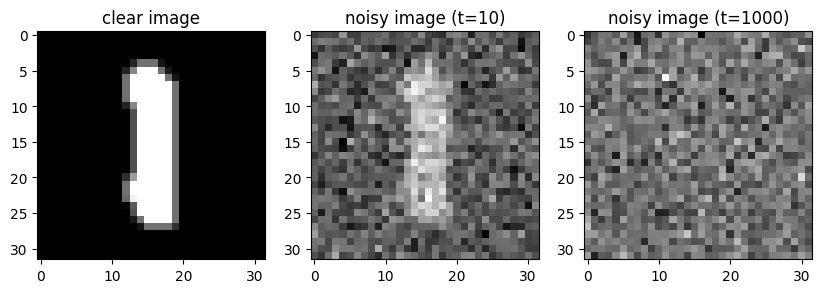

In [45]:
sample_image = train_set[0][0]

# Make a noisy image
epsilon = torch.randn_like(sample_image)
alpha_t = 0.99
noisy_image = add_noise(alpha_t, sample_image, torch.tensor(10))
more_noisy_image = add_noise(alpha_t, sample_image, torch.tensor(1000))

# Plot the clear image and the noisy image
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(sample_image.squeeze(0), cmap='gray')
axs[0].set_title('clear image')
axs[1].imshow(noisy_image.squeeze(0), cmap='gray')
axs[1].set_title('noisy image (t=10)')
axs[2].imshow(more_noisy_image.squeeze(0), cmap='gray')
axs[2].set_title('noisy image (t=1000)')
plt.show()

In [46]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128,128,256,512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

In [51]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

lossTrain = []
lossTest = []

num_epochs = 5

for epoch in range(num_epochs):
    train_loss_epoch = 0.
    test_loss_epoch = 0.

    for i, (data, target) in enumerate(train_loader):
        # Set model in training mode
        model.train() 
        # Generate a random timestep for each image
        t = torch.randint(2, 1000, size=(32,)).to(device)
        data = data.to(device)
        alpha_t = 0.99
        # Add noise to the batch of images
        noisy_data = torch.empty_like(data)
        for j in range(data.size(0)):
            noisy_data[j] = add_noise(alpha_t, data[j], t[j])

        # Compute batch predictions
        noise_pred = model(noisy_data, t)[0]

        # Compute loss
        train_loss = F.mse_loss(noise_pred, data)

        # Compute gradients of loss w respect to current params
        train_loss.backward()

        # Update params using SGD
        optimizer.step()

        # Accumulate batch losses
        train_loss_epoch += train_loss.item()

        # Clear gradients of previous batch
        optimizer.zero_grad()
        print("iter %d, train loss %f" % (i, train_loss.item()))
    print("Epoch %d, train loss %f" % (epoch, train_loss_epoch))
    # Update learning rate
    lr_scheduler.step()

    for data, target in test_loader:
        # Set the model to evaluation mode.
        model.eval()
        with torch.no_grad():
            # Generate a random timestep for each image
            t = torch.randint(2, 1000, size=(32,)).to(device)
            alpha_t = 0.99
            
            data=data.to(device)
        
            # Add noise to the batch of images
            noisy_data = torch.empty_like(data)
            for i in range(data.size(0)):
                noisy_data[i] = add_noise(alpha_t, data[i], t[i])

            # Compute batch predictions
            noise_pred = model(noisy_data, t)[0]
            # Compute loss
            test_loss = F.mse_loss(noise_pred, data)
            test_loss_epoch += test_loss.item()

    lossTrain.append(train_loss_epoch/len(train_loader))
    lossTest.append(test_loss_epoch/len(test_loader))

    print(f"Epoch: {epoch} \t Train Loss: {train_loss_epoch/len(train_loader):.3f} \t TestLoss: {test_loss_epoch/len(test_loader):.3f}")
print(f"Final Training Loss: {lossTrain[-1]:.2f}")
print(f"Final Test Loss: {lossTest[-1]:.2f}")

iter 0, train loss 0.048549
iter 1, train loss 0.058365
iter 2, train loss 0.054431
iter 3, train loss 0.051630
iter 4, train loss 0.057616
iter 5, train loss 0.046406
iter 6, train loss 0.052716
iter 7, train loss 0.057433
iter 8, train loss 0.054221
iter 9, train loss 0.051336
iter 10, train loss 0.046772
iter 11, train loss 0.054076
iter 12, train loss 0.051467
iter 13, train loss 0.049293
iter 14, train loss 0.048810
iter 15, train loss 0.048631
iter 16, train loss 0.058845
iter 17, train loss 0.055119
iter 18, train loss 0.048964
iter 19, train loss 0.054916
iter 20, train loss 0.051588
iter 21, train loss 0.051360
iter 22, train loss 0.046741
iter 23, train loss 0.050830
iter 24, train loss 0.052862
iter 25, train loss 0.048621
iter 26, train loss 0.050563
iter 27, train loss 0.054187
iter 28, train loss 0.051428
iter 29, train loss 0.050334
iter 30, train loss 0.042100
iter 31, train loss 0.048615
iter 32, train loss 0.048750
iter 33, train loss 0.052705
iter 34, train loss 0.05

timesteps 938
timesteps 551
timesteps 992
timesteps 572
timesteps 921
timesteps 961
timesteps 912
timesteps 545
timesteps 826
timesteps 763


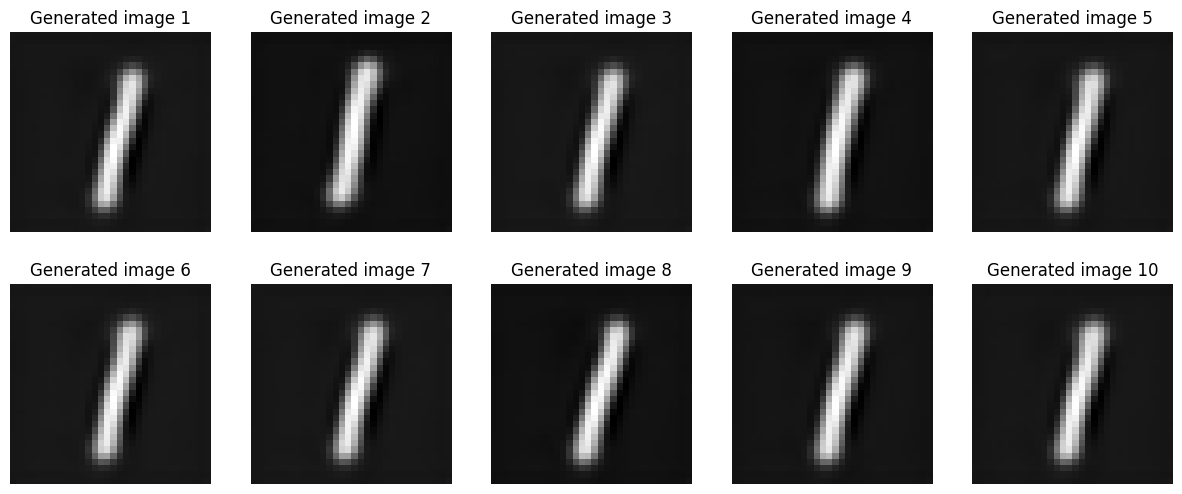

In [52]:
# Generating images
noise = torch.randn([1, 1, 32, 32])
generated_images = []

model.eval()
num_timesteps_list = torch.tensor([random.randint(500, 1000) for _ in range(10)]).to(device)
alpha_t = 0.99
with torch.no_grad():
    for num_timesteps in num_timesteps_list:
        print("timesteps %d" % num_timesteps.item())
        x_t = torch.randn([1, 1, 32, 32]).to(device)
        for t in reversed(range(1, num_timesteps)):
            timestep = torch.tensor([t/num_timesteps]).to(device)
            x_theta = model(x_t, timestep, return_dict=False)[0]
            alpha_bar_t = alpha_t ** t
            alpha_bar_t_1 = alpha_t ** (t-1)
            x_t = 1 / (1 - alpha_bar_t) * (np.sqrt(alpha_t) * (1 - alpha_bar_t_1) * x_t + np.sqrt(alpha_bar_t_1) * (1 - alpha_t) * x_theta)
        generated_images.append(x_t.detach().cpu().squeeze().squeeze().numpy())

# Visualize the output
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Generated image {idx + 1}')
plt.show()